### Projected terrestrial carbon anomalies in UKESM1 model output

The data used for this investigation was derived from a single UKESM1 run using its default low-resolution setup. The run followed the historical setup from 1850-2014 (Eyring et al., 2016), and branched at 2015 into different scenarios for the years 2015-2100 based on shared socioeconomic pathways (SSPs) and climate outcomes for 2100 driven by prescribed radiative forcings (O’Neill et al., 2016). To assess changes to the terrestrial carbon pool, variables analysed were soil carbon and vegetation carbon. The regional focus was the northern permafrost zone, consisting of latitudes greater than 60 degres N.

In [1]:
#load packages
import xarray as xr
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.patches as patches
%matplotlib inline

In [2]:
#calculate area of land for each cell
areacell = xr.open_dataset('../02-data/ukesm1-output/areacella_fx_UKESM1-0-LL_piControl_r1i1p1f2_gn.nc')
lndfrac = xr.open_dataset('../02-data/ukesm1-output/sftlf_fx_UKESM1-0-LL_piControl_r1i1p1f2_gn.nc')

acl = areacell['areacella'].values
lfr = lndfrac['sftlf'].values
lp = lfr/100
lndarea = np.multiply(acl,lp)

#set lat and lon
lat = areacell['lat']
lon = areacell['lon']

In [45]:
#functions to load data and derive anomaly compared to 1850-1900 baseline

def load_mass(info):
    '''function to load data for variable and scenario
    Arguments:
    =========
    info = array of str, ccontaining variable[0], letter[1], scenario[2]'''
    path1 = f'../02-data/ukesm1-output/{info[0]}_{info[1]}mon_UKESM1-0-LL_historical_r1i1p1f2_gn_*.nc'
    path2 = f'../02-data/ukesm1-output/{info[0]}_{info[1]}mon_UKESM1-0-LL_{info[2]}_r1i1p1f2_gn_*.nc'
    data1 = xr.open_mfdataset(paths=path1,combine='by_coords')
    data2 = xr.open_mfdataset(paths=path2,combine='by_coords')
    data3 = xr.concat([data1,data2],dim='time')
    
    data4 = data3.assign(mass = data3[info[0]]*lndarea)
    return data4

def get_anom(info,startyear,endyear,latmin,latmax):
    
    data = load_mass(info)
    
    #get baseline
    d = data.sel(time=slice('1850-01-01','1900-12-16'))
    d1 = d['mass']
    d2 = d1.mean(dim='time')
    d3 = d2.sel(lat=slice(latmin,latmax))
    bl = d3.sum(dim=('lat','lon'))
    
    #get total
    m = data.sel(time=slice(f'{startyear}-01-01',f'{endyear}-12-16'))
    m1 = m.groupby('time.year').mean('time')
    m2 = m1['mass']
    m3 = m2.sel(lat=slice(latmin,latmax))
    ttl = m3.sum(dim=('lat','lon'))
    
    anom = ttl-bl
    
    return anom

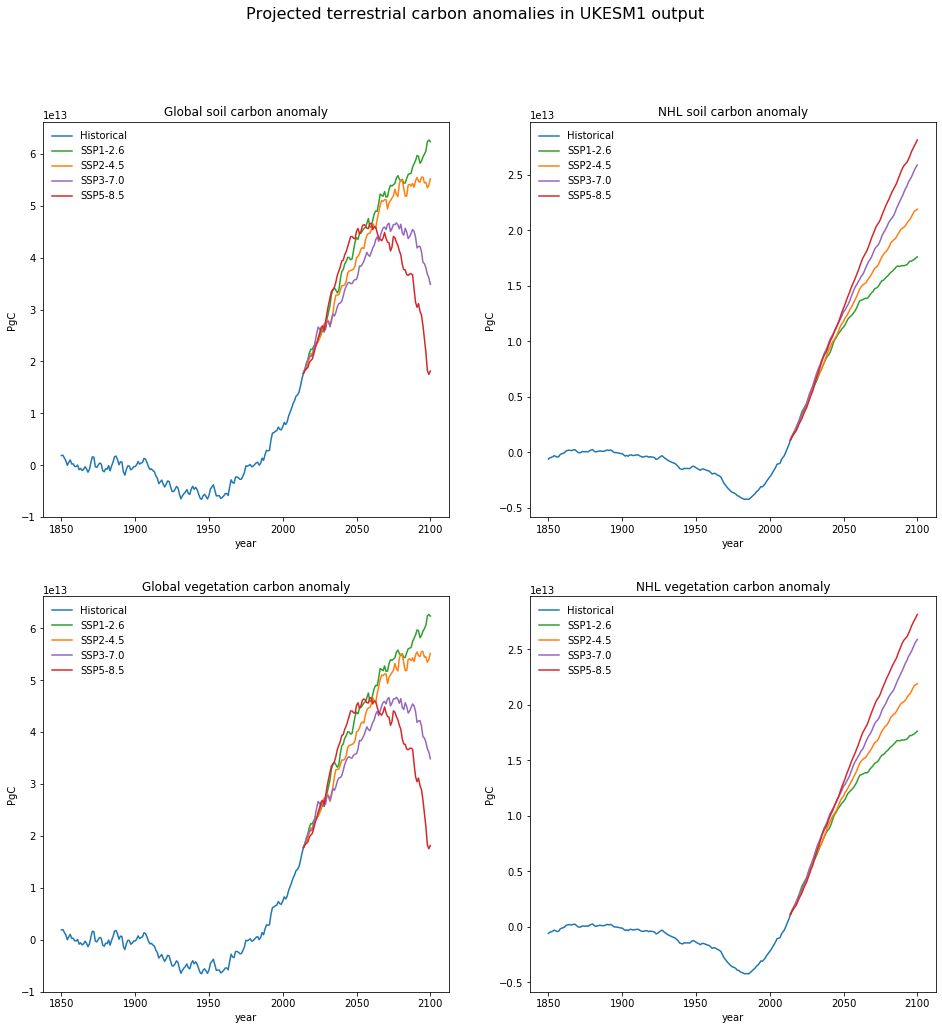

In [65]:
import warnings
warnings.simplefilter("ignore") 

#set up figure

fig,axes = plt.subplots(nrows=2,ncols=2,figsize=(16,16))
fig.suptitle('Projected terrestrial carbon anomalies in UKESM1 output',fontsize=16)
titles = ('Global soil carbon anomaly','NHL soil carbon anomaly','Global vegetation carbon anomaly',
          'NHL vegetation carbon anomaly')
var = ('cSoil','cVeg','cSoil','cVeg')
n = ('E','L','E','L')
scen = ('ssp126','ssp245','ssp370','ssp585')
latmin = (-90,60,-90,60)
colours = ('#2CA02C','#FF7F0E','#9467BD','#D62728')
labels = ('SSP1-2.6','SSP2-4.5','SSP3-7.0','SSP5-8.5')

x=range(2014,2101)
y=range(1850,2015)

#plot on subplot
for ax,v,n,l,t in zip(axes.flat,var,n,latmin,titles):
    ax.set_title(t)
    ax.set(ylabel='PgC')
    ax.set(xlabel='year')
    ax.plot(y,get_anom([v,n,'ssp126'],1850,2014,l,90),color='#1F77B4',label='Historical')
    for s,c,la in zip(scen,colours,labels):      
        ax.plot(x,get_anom([v,n,s],2014,2100,l,90),color=c,label=la)
    ax.legend(loc='best',frameon=False)


### References

Eyring, V. et al. (2016) Overview of the Coupled Model Intercomparison Project Phase 6 (CMIP6) experimental design and organization. Geoscientific Model Development. [Online] 9 (5), 1937–1958.

O’Neill, B. C. et al. (2016) The Scenario Model Intercomparison Project (ScenarioMIP) for CMIP6. Geoscientific Model Development. [Online] 9 (9), 3461–3482.